In [1]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install "dask[dataframe]"

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 3.3 MB/s eta 0:00:00


In [3]:
!pip install sktime==0.32.4
!pip install polars==0.16.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 kB 8.3 MB/s eta 0:00:00
ERROR: Ignored the following yanked versions: 0.13.32, 0.13.33, 0.13.35, 0.13.41, 0.13.42, 0.13.43, 0.13.45, 0.13.47, 0.13.48, 0.13.53, 0.13.54, 0.13.56, 0.13.57, 0.14.4, 0.14.12, 0.14.13, 0.14.15, 0.14.20, 0.14.31, 0.15.0, 0.15.3, 0.15.4, 0.15.5, 0.15.10, 0.16.17, 0.17.0, 0.17.1, 0.17.2, 0.17.4, 0.17.6, 0.17.7, 0.17.8, 0.18.1, 0.18.5, 0.18.9, 0.18.10, 0.18.14, 0.19.4, 0.19.8, 0.19.9, 0.19.10, 0.19.16, 0.20.20, 0.20.24, 0.20.27, 0.20.28, 0.20.29, 1.2.0, 1.4.0
ERROR: Could not find a version that satisfies the requirement polars==0.16.0 (from versions: 0.0.1, 0.7.3, 0.7.4, 0.7.5, 0.7.6b1, 0.7.6b2, 0.7.6, 0.7.7, 0.7.8, 0.7.9, 0.7.10b1, 0.7.11, 0.7.12, 0.7.13, 0.7.14, 0.7.15, 0.7.16, 0.7.17, 0.7.18, 0.7.19, 0.8.0b1, 0.8.0b2, 0.8.0, 0.8.1, 0.8.2, 0.8.3, 0.8.4, 0.8.5, 0.8.6, 0.8.8, 0.8.9, 0.8.10, 0.8.11b1, 0.8.11, 0.8.12, 0.8.13b1, 0.

In [4]:
!pip uninstall polars -y

Found existing installation: polars 0.20.2
Uninstalling polars-0.20.2:
  Successfully uninstalled polars-0.20.2


In [104]:
# Import necessary libraries and packages
import numpy as np
import pandas as pd

import sklearn
import scipy as scp
import openpyxl
import sktime as skt

import xgboost as xgb

from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTEENN

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Supress SettingWithCopyWarning
pd.options.mode.chained_assignment= None

In [6]:
# Load the dataset
df= pd.read_excel('/content/drive/My Drive/TimeSeries_Elevator_Failure_Pred/data/elevator_failure_prediction.xlsx')

# Create a dictionary of the excel sheets
df.head()

,Time,Temperature,Humidity,RPM,Vibrations,Pressure,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,Status
0,2020-01-01 00:00:00,31.11716,74.1715,72.0,16.81,76,0.791225,203.793426,0.582975,799.101683,7.149643,15.842287,0
1,2020-01-01 00:01:00,31.11716,74.1715,72.0,16.81,76,0.791225,203.793426,0.582975,799.101683,7.149643,15.842287,0
2,2020-01-01 00:02:00,32.08894,74.0803,72.0,17.08,76,0.803988,204.411886,0.575500,834.897700,7.089729,15.739743,0
3,2020-01-01 00:03:00,31.67221,73.9272,72.0,15.79,76,0.743260,204.363994,0.575500,805.467950,7.135375,15.731202,0
4,2020-01-01 00:04:00,31.95202,73.7603,72.0,16.84,76,0.792391,203.947834,0.584042,822.142650,7.092582,15.773928,0


In [7]:
# Explore the data
print('Dataset Shape: ', df.shape)
print('Dataset Columns: ', df.columns)

Dataset Shape:  (44640, 13)
Dataset Columns:  Index(['Time', 'Temperature', 'Humidity', 'RPM', 'Vibrations', 'Pressure',
       'Sensor1', 'Sensor2', 'Sensor3', 'Sensor4', 'Sensor5', 'Sensor6',
       'Status'],
      dtype='object')


In [8]:
# Convert columns to snake_case format
cols_map = {
    'Time': 'time',
    'Temperature': 'temperature',
    'Humidity': 'humidity',
    'RPM': 'rpm',
    'Vibrations': 'vibrations',
    'Pressure': 'pressure',
    'Sensor1': 'sensor1',
    'Sensor2': 'sensor2',
    'Sensor3': 'sensor3',
    'Sensor4': 'sensor4',
    'Sensor5': 'sensor5',
    'Sensor6': 'sensor6',
    'Status': 'status'
}

# Apply mapping to rename the columns
df= df.rename(columns= cols_map)

In [9]:
# Display dataset summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44640 entries, 0 to 44639
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time         44640 non-null  datetime64[ns]
 1   temperature  44631 non-null  float64       
 2   humidity     44640 non-null  float64       
 3   rpm          44640 non-null  float64       
 4   vibrations   44640 non-null  float64       
 5   pressure     44640 non-null  int64         
 6   sensor1      44640 non-null  float64       
 7   sensor2      40586 non-null  float64       
 8   sensor3      44640 non-null  float64       
 9   sensor4      44640 non-null  float64       
 10  sensor5      44640 non-null  float64       
 11  sensor6      44640 non-null  float64       
 12  status       44640 non-null  int64         
dtypes: datetime64[ns](1), float64(10), int64(2)
memory usage: 4.4 MB


In [10]:
# Inspect a row of the dataset
df.iloc[1000]

,1000
time,2020-01-01 16:40:00
temperature,38.60568
humidity,73.9486
rpm,72.0
vibrations,13.01
pressure,76
sensor1,0.612267
sensor2,204.218814
sensor3,0.959879
sensor4,825.31645


In [11]:
# Check the distribution of the target variable 'Status'
df['status'].value_counts().sort_index()

,count
status,
0,40584
1,2
2,4054


### Status Column Interpretation:
- **0**: Normal operation
- **1**: Broken (failure)
- **2**: Recovering (after failure)

In [12]:
# Check if there any missing time points
df['time'].iloc[[0,-1]]

,time
0,2020-01-01 00:00:00
44639,2020-01-31 23:59:00


In [13]:
# Confirm if there any missing time points with calculation
31 * 24 * 60 == len(df)

True

- This indicates that there are no missing time points.

In [14]:
# Set time as the index of the DataFrame
df.set_index('time', inplace= True)

In [15]:
# Split the data
def time_train_test_split(data, proportion= 0.8):
  split_point= int(len(data) * proportion)
  train= data.iloc[:split_point]
  test= data.iloc[split_point:]
  return train, test

# Apply the function
train, test= time_train_test_split(df, proportion= 0.8)

In [16]:
# Define a function to check target split
def check_target_split(train, test, target_column= 'status'):
  print('Train Target Distribution:')
  print(train[target_column].value_counts())

  print('\nTest Target Distribution:')
  print(test[target_column].value_counts())

# Check the target distribution
check_target_split(train, test, target_column= 'status')

Train Target Distribution:
status
0    31656
2     4054
1        2
Name: count, dtype: int64

Test Target Distribution:
status
0    8928
Name: count, dtype: int64


### Dataset Imbalance
The target variable `status` is highly imbalanced, with the majority of instances representing normal operation (`status = 0`), and very few instances of failures (`status = 1`) or recovery (`status = 2`). The initial test split contains only `status = 0`, which is not ideal for model evaluation.

To address this, the data will be split again to ensure that the training and test sets contain a more balanced distribution of all target classes.


In [17]:
# Make another split
train, test= time_train_test_split(df, proportion= 0.5)

# Check the target distribution in the new split
check_target_split(train, test, target_column= 'status')

Train Target Distribution:
status
0    21375
2      944
1        1
Name: count, dtype: int64

Test Target Distribution:
status
0    19209
2     3110
1        1
Name: count, dtype: int64


### Merging Broken and In Repair Statuses
Due to the low occurrence of the `broken` status (`status = 1`), it will be combined with the `in repair` status (`status = 2`) later in the analysis. This approach will reduce the imbalance in the dataset and improve the model's ability to learn from these instances.


### Splitting the Data Based on Days

The data splitting process begins by checking the distribution of full days in the current train and test sets. This ensures that each split contains complete daily cycles, preventing uneven distributions of data across time.

Rather than using a typical split ratio like 80/20 or 50/50, the dataset is divided based on a time-based proportion, with 14 days assigned to the training set and the remaining days to the test set. This method maintains the integrity of the time series structure.

 After the split, the distribution of the `status` target variable is re-evaluated to ensure a balanced split between the train and test sets, while also confirming that both sets contain full days for consistent analysis.


In [18]:
# Define a function to check number of full days
def check_number_of_full_days(data_index):

  # Convert to datetime if its  not already a DatetimeIndex
  if not isinstance(data_index, pd.DatetimeIndex):
    data_index= pd.to_datetime(data_index)

  # Create a DataFrame with the date and corresponding day of the week
  days_df= pd.DataFrame(data_index, columns= ['date'])

  # Extract the dates and calculate the day of the week
  days_df['weekday']= data_index.weekday

  # Map the weekday integers to day names
  day_mapping= {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
                   4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
  days_df['weekday']= days_df['weekday'].map(day_mapping)

  # Define the weekday order
  weekday_order= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
  days_df['weekday']= pd.Categorical(days_df['weekday'], categories= weekday_order, ordered= True)

  # Group by weekday and count the ocurrences per day
  full_day_counts= days_df.groupby('weekday').size()

  # Calculate the number of full days for each weekday
  full_days_by_weekday= full_day_counts / (24 * 60) # 1440 minutes in a day

  # Print the result
  print(full_days_by_weekday)

In [19]:
# Check the distribution of full days in the current train set
check_number_of_full_days(train.index)

weekday
Monday       2.0
Tuesday      2.0
Wednesday    3.0
Thursday     2.5
Friday       2.0
Saturday     2.0
Sunday       2.0
dtype: float64


In [20]:
# Make another split based on days (14 days for training, 17 days for testing)
train, test= time_train_test_split(df, proportion= 14/31)

# Check the target distribution in the new split
check_target_split(train, test, target_column= 'status')

# Check the distribution of full days in the new train set
print('-' * 50)
check_number_of_full_days(train.index)

Train Target Distribution:
status
0    19215
2      944
1        1
Name: count, dtype: int64

Test Target Distribution:
status
0    21369
2     3110
1        1
Name: count, dtype: int64
--------------------------------------------------
weekday
Monday       2.0
Tuesday      2.0
Wednesday    2.0
Thursday     2.0
Friday       2.0
Saturday     2.0
Sunday       2.0
dtype: float64


In [21]:
# Use the splitter with a 30 minute window and predict the final minute of the window (fh= 0)
splitter_30_present= SlidingWindowSplitter(window_length= 30, step_length= 1, fh= 0)

# Generate the first split
next(splitter_30_present.split(df.index))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([29]))

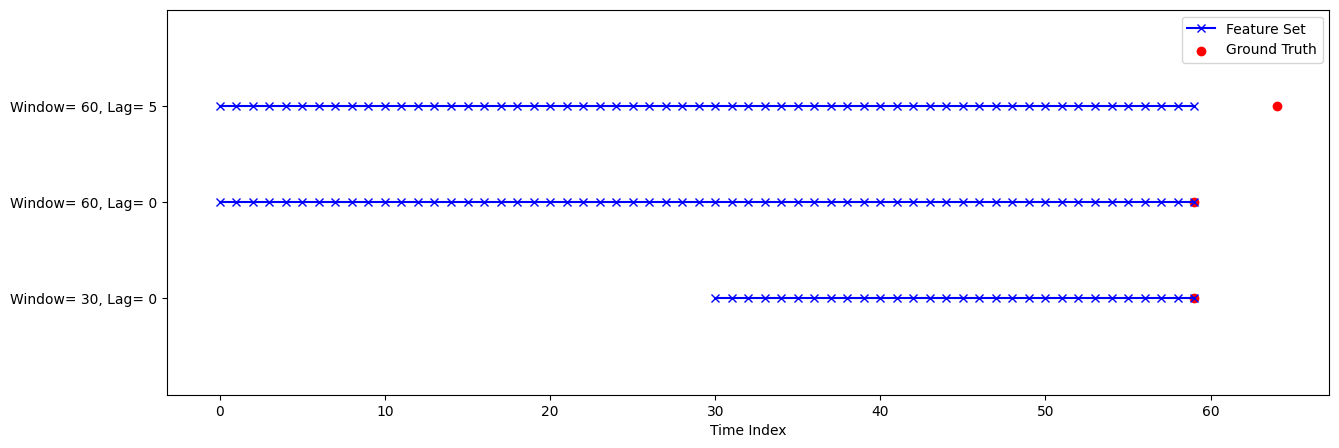

In [22]:
# Visualize the splitter configuration
fig, ax= plt.subplots(figsize= (15,5))

# Visualize the time index and window
ax.plot(np.arange(30,60), np.repeat(1,30), marker= 'x', color= 'b')
ax.scatter([59], [1], marker= 'o', color= 'r')

ax.plot(np.arange(60), np.repeat(2,60), marker= 'x', color= 'b')
ax.scatter([59], [2], marker= 'o', color= 'r')

ax.plot(np.arange(60), np.repeat(3,60), marker= 'x', color= 'b', label= 'Feature Set')
ax.scatter([64], [3], marker= 'o', color= 'r', label= 'Ground Truth')

ax.legend()
ax.set_yticks([1,2,3])
ax.set_yticklabels(['Window= 30, Lag= 0', 'Window= 60, Lag= 0', 'Window= 60, Lag= 5'])
ax.set_ylim(0,4)
ax.set_xlabel('Time Index')
plt.show()

### Sliding Window Visualization for Elevator Failure Prediction

This image illustrates three different sliding window configurations used for time series predictions in the context of elevator failure prediction. The **blue crosses** represent the data points used as input features, while the **red circles** represent the points being predicted (ground truth).

1. **Window = 60, Lag = 5**:
   - The top line shows the configuration where a **60-minute window** of past data is used to predict **5 minutes into the future**. The blue crosses indicate the 60 data points used for input, and the red circle at index 64 represents the ground truth prediction, which is 5 minutes after the end of the window.
   - **Implication**: This configuration helps anticipate potential failures slightly ahead of time (5 minutes in the future), which could be useful for proactive maintenance.

2. **Window = 60, Lag = 0**:
   - The middle line represents a **60-minute window** where the final data point of the window (index 59) is predicted. The ground truth coincides with the end of the input window.
   - **Implication**: This configuration makes predictions based on the immediate data, meaning it's reacting to the latest available information without forecasting beyond the window.

3. **Window = 30, Lag = 0**:
   - The bottom line shows a **30-minute window** of data where the final minute of the window is predicted (index 29). The prediction is made based on a shorter history compared to the previous configurations, which allows for more data points overall (since more windows can be created with the same amount of data).
   - **Implication**: This configuration provides more training data due to the smaller window size and could improve model performance by allowing for more frequent updates and predictions. It doesn't predict beyond the current window, making it a responsive model to immediate data.

### Conclusion:
- **Window = 60, Lag = 5** is beneficial if the goal is to predict future failures with a small buffer (5 minutes ahead), which allows for early action.
- **Window = 60, Lag = 0** and **Window = 30, Lag = 0** are more reactive configurations, predicting failure immediately at the end of the current data window. The **30-minute window** option offers more data points, which can improve model robustness.
- For elevator failure prediction, choosing between these configurations depends on whether immediate reaction or short-term foresight (5-minute lead time) is more important for preventing elevator malfunctions.


In [23]:
# Function to create sliding windows of features and corresponding labels (targets)
def create_windows(data, window_size= 30, horizon= 1):
    """
    Function to create sliding windows of time series data for machine learning.

    Parameters:
    - data: DataFrame, the input data that includes time-series data with features and a target.
    - window_size: int, the number of time steps in each window (default is 30).
    - horizon: int, how far into the future to predict (default is 1).

    Returns:
    - X: Numpy array of sliding windows (features).
    - y: Numpy array of corresponding labels (targets).
    """

    # Initialize empty lists for features (X) and labels (y)
    X= []
    y= []

    # Print the shape and columns of the input data
    print(f"Data shape: {data.shape}")
    print(f"Columns: {data.columns}")

    # Sort the data by its index (assumes the index is time-based)
    data= data.sort_index()

    # Loop through the data to create sliding windows
    for i in range(len(data) - window_size - horizon + 1):
        print(f"Processing window {i} to {i+window_size}...")

        try:

            # Extract the sliding window of features
            window= data.iloc[i:i+window_size]
            target_index= i + window_size + horizon - 1

            # Stop if the target index is out of bounds
            if target_index >= len(data):
                print(f"Target index {target_index} is out of bounds. Stopping.")
                break

            # Select all columns except 'status' as features
            feature_columns= [col for col in data.columns if col != 'status']
            X.append(window[feature_columns].values)

            # Append the target ('status') for the current window
            if 'status' in data.columns:
                y.append(data['status'].iloc[target_index])
            else:

                # If there's no 'status' column, use the last column as the target
                y.append(data.iloc[target_index, -1])

            # Print success message for each window
            print(f"Successfully added window {i}. X length: {len(X)}, y length: {len(y)}")

        # Exception handling in case of an error in processing a window
        except Exception as e:
            print(f"Error occurred at window {i}: {str(e)}")
            print(f"Data at window {i}: \n{data.iloc[i:i+window_size]}")
            break

    # Print final lengths of X and y arrays
    print(f"Final X length: {len(X)}, y length: {len(y)}")

    # Return the sliding windows (X) and their corresponding labels (y)
    return np.array(X), np.array(y)

In [24]:
# Create windows for the first 100 rows of the dataset
X, y = create_windows(df.iloc[:100], window_size=30, horizon=1)

# Confirm that it worked
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Format the output to look like the image
if len(y) > 5:
    print("y[5]:", y[5])  # Ground truth
    print("X[5] shape:", X[5].shape)

    # Create a DataFrame for X[5] for a nicer display
    window_5_df = pd.DataFrame(X[5], columns=df.columns[:-1], index=df.index[:X[5].shape[0]])

    # Display the DataFrame in a more readable format, similar to the image
    print(window_5_df)
else:
    print(f"Not enough elements in y. Total elements: {len(y)}")

Data shape: (100, 12)
Columns: Index(['temperature', 'humidity', 'rpm', 'vibrations', 'pressure', 'sensor1',
       'sensor2', 'sensor3', 'sensor4', 'sensor5', 'sensor6', 'status'],
      dtype='object')
Processing window 0 to 30...
Successfully added window 0. X length: 1, y length: 1
Processing window 1 to 31...
Successfully added window 1. X length: 2, y length: 2
Processing window 2 to 32...
Successfully added window 2. X length: 3, y length: 3
Processing window 3 to 33...
Successfully added window 3. X length: 4, y length: 4
Processing window 4 to 34...
Successfully added window 4. X length: 5, y length: 5
Processing window 5 to 35...
Successfully added window 5. X length: 6, y length: 6
Processing window 6 to 36...
Successfully added window 6. X length: 7, y length: 7
Processing window 7 to 37...
Successfully added window 7. X length: 8, y length: 8
Processing window 8 to 38...
Successfully added window 8. X length: 9, y length: 9
Processing window 9 to 39...
Successfully added w

In [25]:
# Create a subset of the first four rows and the first four columns
df.iloc[:4, :4]

,temperature,humidity,rpm,vibrations
time,,,,
2020-01-01 00:00:00,31.11716,74.1715,72.0,16.81
2020-01-01 00:01:00,31.11716,74.1715,72.0,16.81
2020-01-01 00:02:00,32.08894,74.0803,72.0,17.08
2020-01-01 00:03:00,31.67221,73.9272,72.0,15.79


In [26]:
# Calculate the difference between 2 periods
df.diff(periods= 2, axis= 0).iloc[:4, :4]

,temperature,humidity,rpm,vibrations
time,,,,
2020-01-01 00:00:00,NaN,NaN,NaN,NaN
2020-01-01 00:01:00,NaN,NaN,NaN,NaN
2020-01-01 00:02:00,0.97178,-0.0912,0.0,0.27
2020-01-01 00:03:00,0.55505,-0.2443,0.0,-1.02


In [27]:
# Extract a small time series from the 'temperature' column
df.temperature.iloc[:10]

,temperature
time,
2020-01-01 00:00:00,31.11716
2020-01-01 00:01:00,31.11716
2020-01-01 00:02:00,32.08894
2020-01-01 00:03:00,31.67221
2020-01-01 00:04:00,31.95202
2020-01-01 00:05:00,32.23816
2020-01-01 00:06:00,32.00982
2020-01-01 00:07:00,31.88320
2020-01-01 00:08:00,32.09234


In [28]:
# Introduce missing values (NaNs) between indices 3 and 7
df_ts= df.temperature.iloc[:10].copy()
ts_nulls= df_ts.copy()
ts_nulls.iloc[3:7]= np.nan
ts_nulls

,temperature
time,
2020-01-01 00:00:00,31.11716
2020-01-01 00:01:00,31.11716
2020-01-01 00:02:00,32.08894
2020-01-01 00:03:00,NaN
2020-01-01 00:04:00,NaN
2020-01-01 00:05:00,NaN
2020-01-01 00:06:00,NaN
2020-01-01 00:07:00,31.88320
2020-01-01 00:08:00,32.09234


<Axes: title={'center': 'Original Temperature Data'}, xlabel='time'>

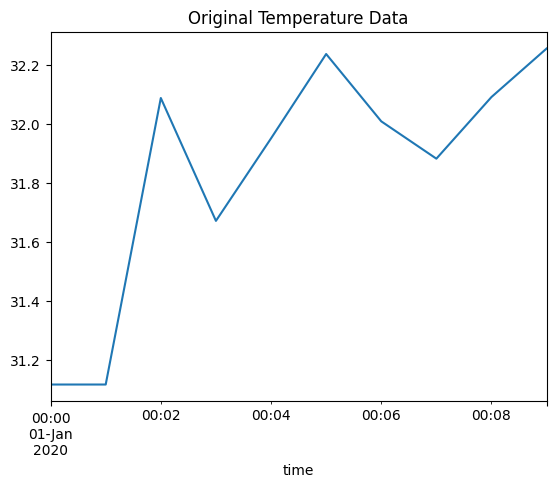

In [29]:
# Plot the original series
df_ts.plot(title= 'Original Temperature Data')

### Original Temperature Data

- The temperature fluctuates slightly within a narrow range between approximately 31.2°C and 32.2°C.
- There's a noticeable spike around the 00:02 mark, where the temperature rises sharply, followed by a gradual decrease and stabilization.
- The temperature seems to follow a general upward trend towards the end of the time frame, indicating possible environmental changes or system activity.


<Axes: title={'center': 'Temperature with Missing Values'}, xlabel='time'>

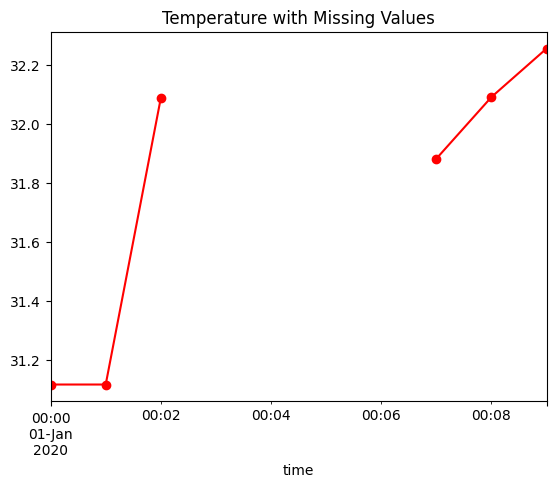

In [30]:
# Plot the original series with missing values
ts_nulls.plot(title= 'Temperature with Missing Values', marker= 'o', color= 'red', label= 'With Missing Values')

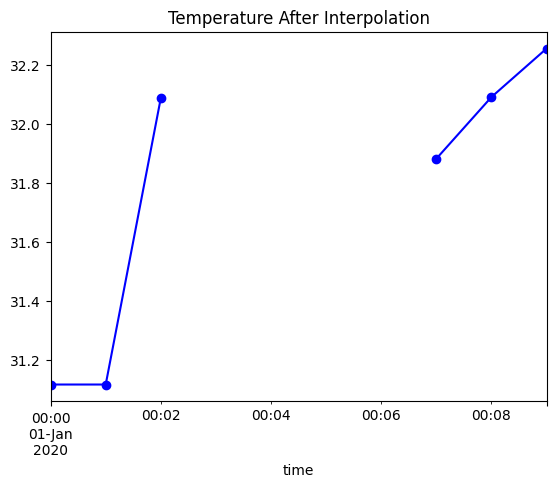

In [31]:
# Fill missing values using backward fill (bfill) interpolation
ts_filled= ts_nulls.interpolate(method= 'bfill', limit= 2, limit_area= 'outside')

# Plot the filled series after interpolation
ts_filled.plot(title= 'Temperature After Interpolation', marker= 'o', color= 'blue', label= 'Interpolated')
plt.show()

In [32]:
# Using diff method to calculate differences
df_diff= df[['temperature', 'humidity']].diff(periods= 2, axis= 0).iloc[:10]

# Display the first few rows after using the diff method
print('Temperature and Humidity Differences:')
df_diff

Temperature and Humidity Differences:


,temperature,humidity
time,,
2020-01-01 00:00:00,NaN,NaN
2020-01-01 00:01:00,NaN,NaN
2020-01-01 00:02:00,0.97178,-0.0912
2020-01-01 00:03:00,0.55505,-0.2443
2020-01-01 00:04:00,-0.13692,-0.3200
2020-01-01 00:05:00,0.56595,-0.0068
2020-01-01 00:06:00,0.05780,0.3349
2020-01-01 00:07:00,-0.35496,0.2255
2020-01-01 00:08:00,0.08252,0.2645


In [33]:
# Confirming datetime index type
print(f'Type of df.index: {type(df.index)}')

Type of df.index: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [34]:
# Extract and inspect the first index value
i= df.index[0]
print(f'First index: {i}, Type: {type(i)}')

First index: 2020-01-01 00:00:00, Type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [35]:
# Extract components from the datetime index
print(f'Hour of first index: {i.hour}')

Hour of first index: 0


In [36]:
# Add time offset to the datetime index
df_offset= df.index + pd.DateOffset(hours= 1, minutes= 1)
print(f'New offset datetime index: {df_offset}')

New offset datetime index: DatetimeIndex(['2020-01-01 01:01:00', '2020-01-01 01:02:00',
               '2020-01-01 01:03:00', '2020-01-01 01:04:00',
               '2020-01-01 01:05:00', '2020-01-01 01:06:00',
               '2020-01-01 01:07:00', '2020-01-01 01:08:00',
               '2020-01-01 01:09:00', '2020-01-01 01:10:00',
               ...
               '2020-02-01 00:51:00', '2020-02-01 00:52:00',
               '2020-02-01 00:53:00', '2020-02-01 00:54:00',
               '2020-02-01 00:55:00', '2020-02-01 00:56:00',
               '2020-02-01 00:57:00', '2020-02-01 00:58:00',
               '2020-02-01 00:59:00', '2020-02-01 01:00:00'],
              dtype='datetime64[ns]', name='time', length=44640, freq=None)


In [37]:
# Create new data range starting from the first index 'i', ending 1 minute later with a frequency of 1 second
new_range= pd.date_range(start= i, end= i + pd.DateOffset(minutes= 1), freq= 's')

# Create a new DataFrame with this time range as the index and a column for 'sensors1'
df_new= pd.DataFrame(index= new_range, columns= ['sensors1'])

# Display the new DataFrame
df_new

,sensors1
2020-01-01 00:00:00,NaN
2020-01-01 00:00:01,NaN
2020-01-01 00:00:02,NaN
2020-01-01 00:00:03,NaN
2020-01-01 00:00:04,NaN
...,...
2020-01-01 00:00:56,NaN
2020-01-01 00:00:57,NaN
2020-01-01 00:00:58,NaN
2020-01-01 00:00:59,NaN


### Purpose of Time Index Manipulation Code

This code ensures accurate handling of the **time index** in the elevator failure prediction analysis. Proper datetime indexing allows:
- **Accurate alignment** of sensor data with timestamps, ensuring the correct order of events.
- **Time offset adjustments** for creating sliding windows, helping the model predict future failures based on past sensor readings.
- **Creating uniform time ranges** to handle missing data or interpolate gaps in sensor readings.
- **Foundation for machine learning models** that rely on past data to predict future outcomes in a time-dependent context.


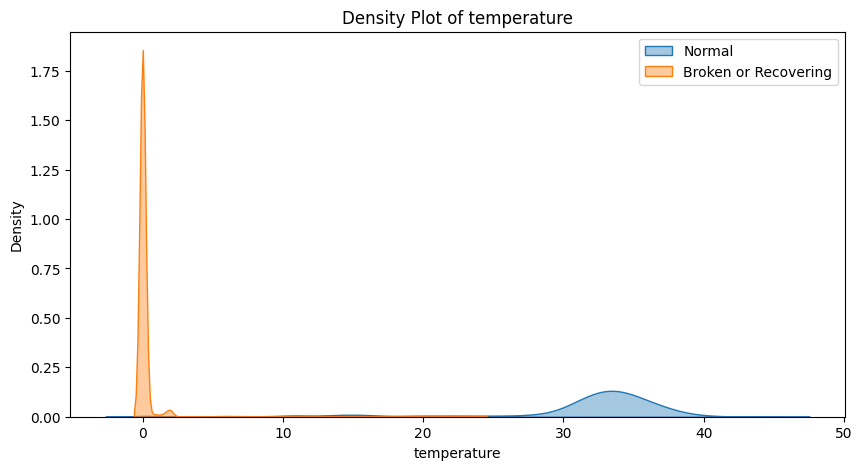

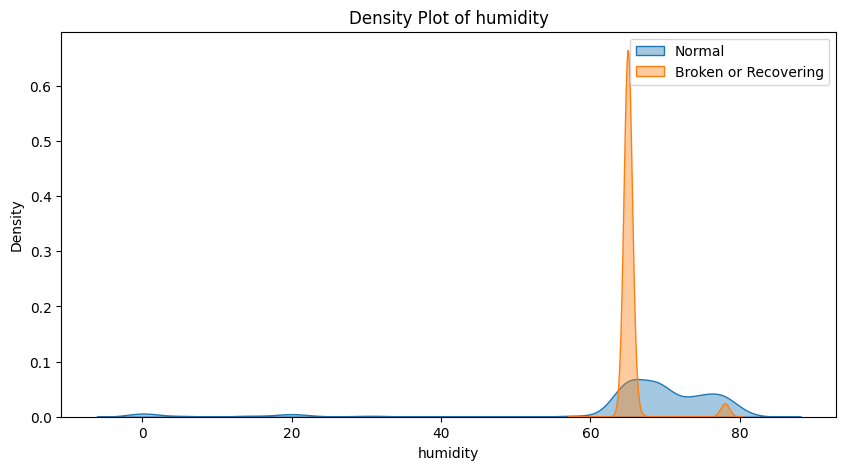

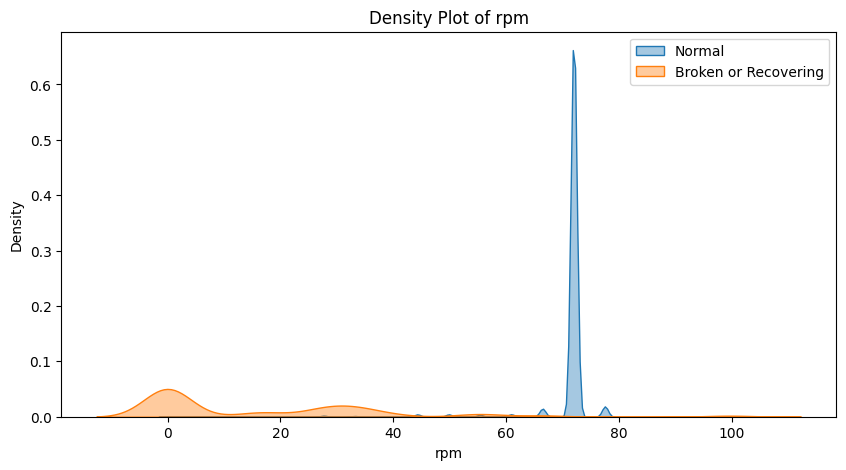

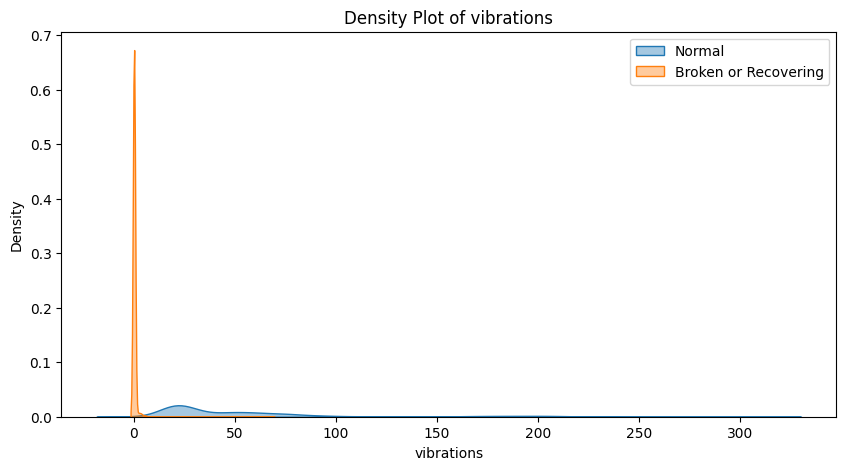

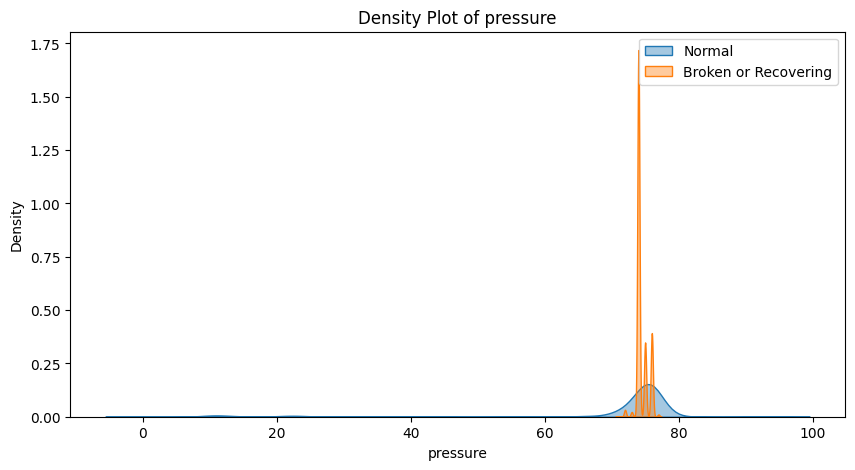

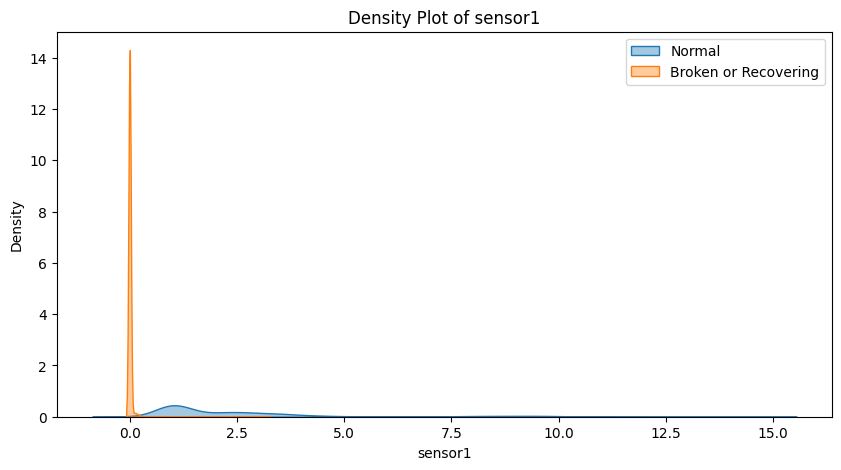

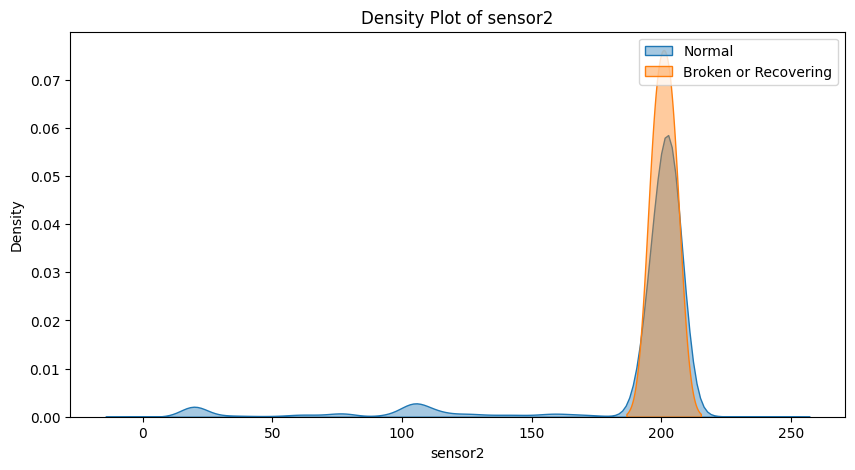

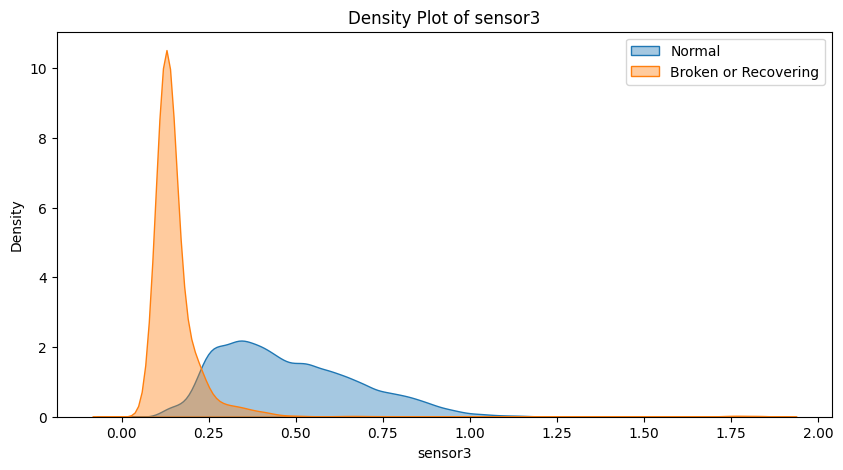

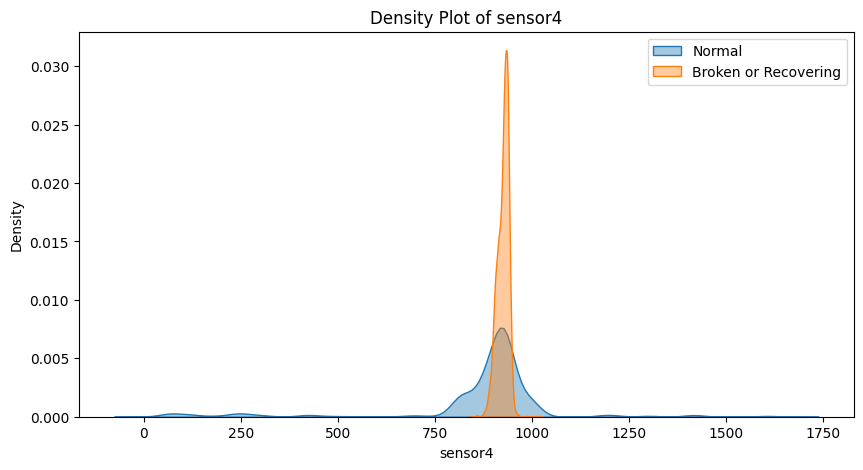

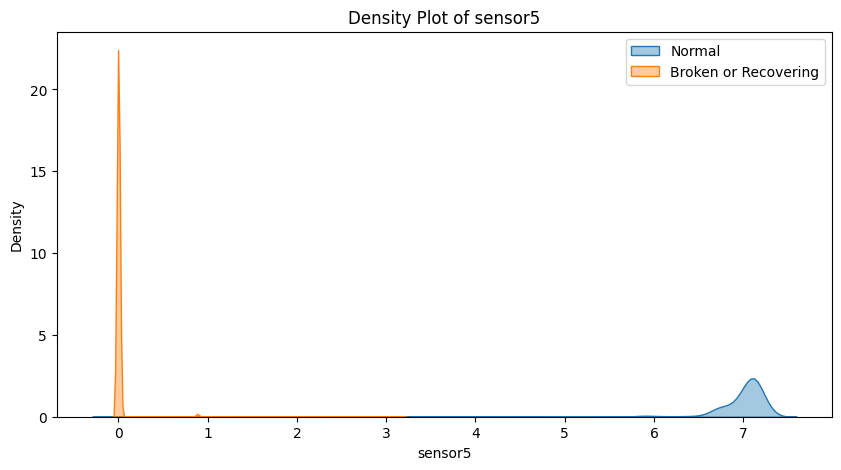

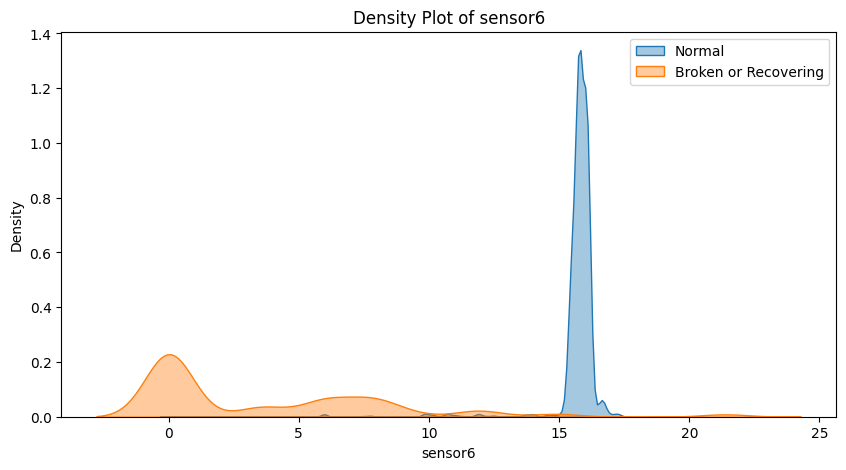

In [38]:
# Dictionary for target groups to split the status into categories
target_groups= {'Normal': [0], 'Broken or Recovering': [1,2]}

# Looping through each column, except the 'status' column, to create density plots
for col in df.columns[:-1]:
  plt.figure(figsize= (10,5))

  # Density plots for each group in 'target_groups'
  for group_name, group_values in target_groups.items():
    sns.kdeplot(
        df[col][df['status'].isin(group_values)],
        label= group_name,
        fill= True,
        alpha= 0.4
    )

  plt.title(f'Density Plot of {col}')
  plt.legend()
  plt.show()

### Density Plot Insights

1. **Temperature:**
   - During normal operation, temperature values are centered around 30-35 degrees.
   - When the system is broken or recovering, temperature significantly drops to values near 0.
   
2. **Humidity:**
   - Humidity shows a distinct peak around 60-80 during both normal operation and failure, but higher peaks are associated with the broken or recovering state.

3. **RPM:**
   - RPM values around 60-70 are seen during normal operation, whereas broken or recovering states result in much lower RPM values distributed around 0-20.

4. **Vibrations:**
   - During normal operation, vibrations are minimal or close to 0.
   - Broken or recovering states show spikes in vibrations, although still on the lower end.

5. **Pressure:**
   - Pressure remains high (~80) during broken or recovering states, whereas it is slightly more distributed during normal operations, but still concentrated around high values.

6. **Sensor1:**
   - During broken or recovering states, Sensor1 values are concentrated near 0.
   - Normal operation sees some higher values, though still with low density.

7. **Sensor2:**
   - Both normal and broken/recovering states show a strong peak at around 200.
   - Sensor2 may not show a significant difference between states.

8. **Sensor3:**
   - Broken or recovering states tend to show sensor3 values near 0, whereas normal operations result in a wider spread of values, though still low (around 0.5).

9. **Sensor4:**
   - Similar to Sensor2, values concentrate around 1000 for both normal and broken states, suggesting a close correlation between states.

10. **Sensor5:**
   - A noticeable concentration at 7 during normal operations, with broken or recovering states concentrating at 0.

11. **Sensor6:**
   - Clear separation in Sensor6 values: normal operation peaks strongly around 15, while broken or recovering states are widely spread below 10.

### Overall Insight:
- Certain sensors like Sensor1 and Sensor6 show significant differences between normal and broken/recovering states.
- Other sensors, like Sensor2 and Sensor4, exhibit similar distributions across both states, indicating potential redundancy or lack of differentiation between normal and faulty states.


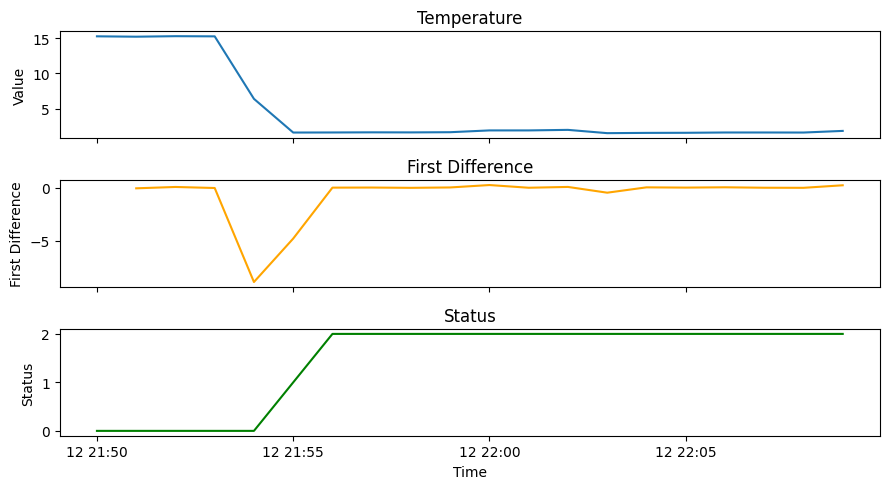

In [39]:
# Define the range for zoomed-in data
start_idx= 17150
end_idx= 17170

# Extract the temperature and status for the selected range
temperature_data= df['temperature'].iloc[start_idx:end_idx]
status_data= df['status'].iloc[start_idx:end_idx]
time_data= df.index[start_idx:end_idx]

# Calculate the first differnce of temperature (rate of change)
first_diff_temp= temperature_data.diff()

# Create the subplots
fig, axes= plt.subplots(nrows= 3, ncols= 1, figsize= (9,5), sharex= True)

# Plot temperature
axes[0].plot(time_data, temperature_data, label= 'Temperature')
axes[0].set_title('Temperature')
axes[0].set_ylabel('Value')

# Plot first difference of temperature
axes[1].plot(time_data, first_diff_temp, label= 'First Differnce', color= 'orange')
axes[1].set_title('First Difference')
axes[1].set_ylabel('First Difference')

# Plot status
axes[2].plot(time_data, status_data, label= 'Status', color= 'green')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Status')
axes[2].set_title('Status')

plt.tight_layout()
plt.show()

### Time Series Insights (Temperature, First Difference, and Status)

1. **Temperature:**
   - There is a sharp drop in temperature from around 15 to below 5 within a short time frame.
   - The temperature stabilizes at this lower level after the drop.

2. **First Difference:**
   - The first difference plot shows a significant negative spike, reflecting the sudden drop in temperature.
   - After this large change, the first difference flattens, indicating no further changes in temperature, which correlates with the stabilized temperature values.

3. **Status:**
   - The status change occurs right after the temperature drop.
   - Status changes from 0 (Normal) to 2 (Recovering or Broken) immediately following the sharp temperature decline, signaling that the system might be in recovery or malfunction after the temperature change.

### Overall Insight:
- The sharp decline in temperature is immediately followed by a change in the system's status, indicating a possible breakdown or malfunction. This temporal correlation suggests that monitoring temperature fluctuations can be critical in predicting status changes or failures in the system.


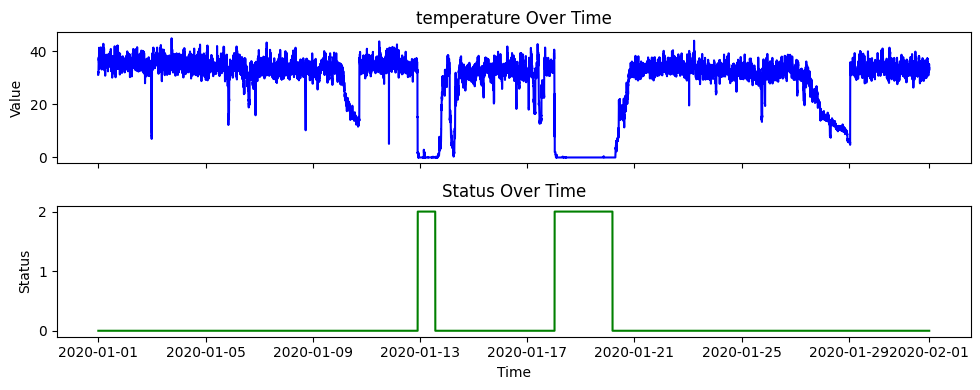

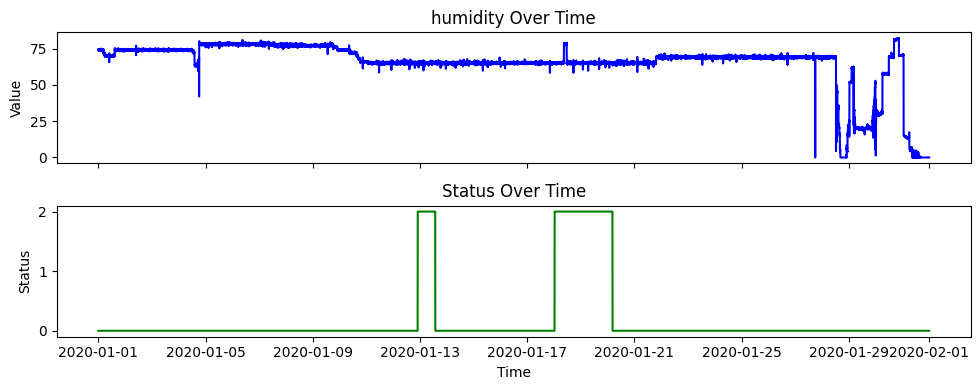

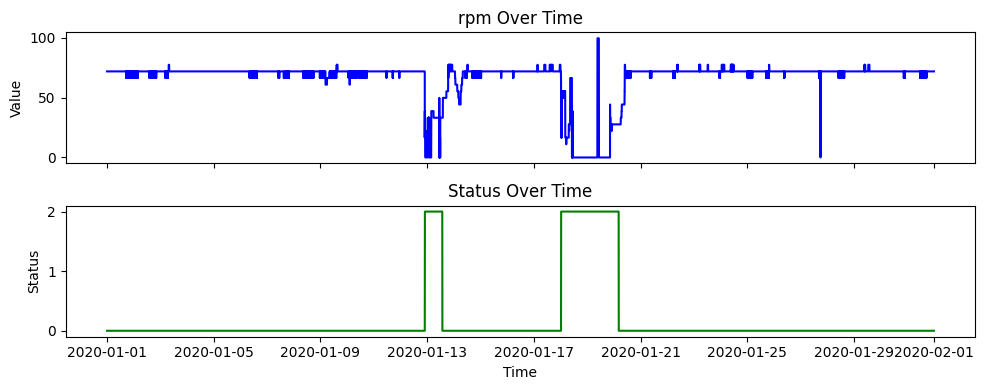

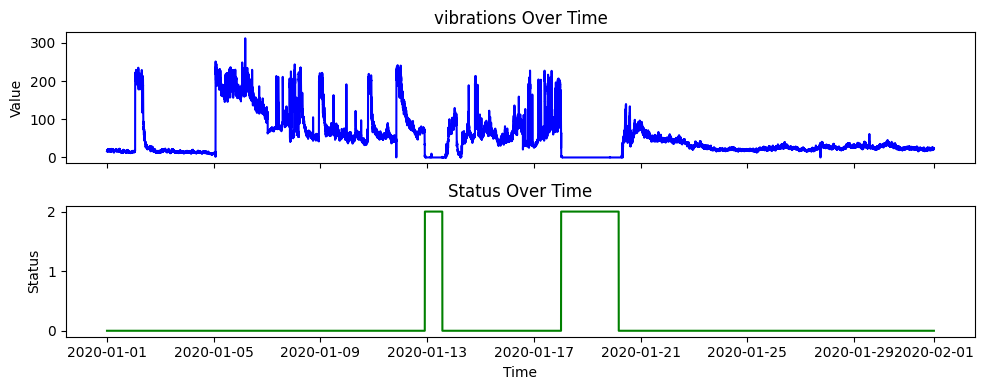

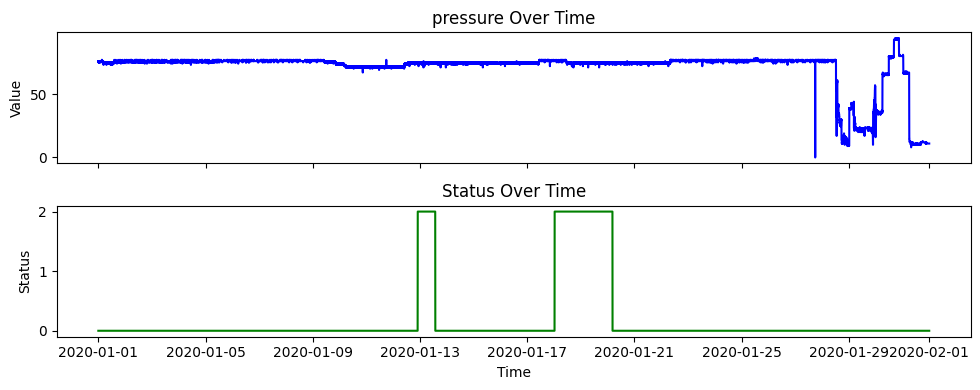

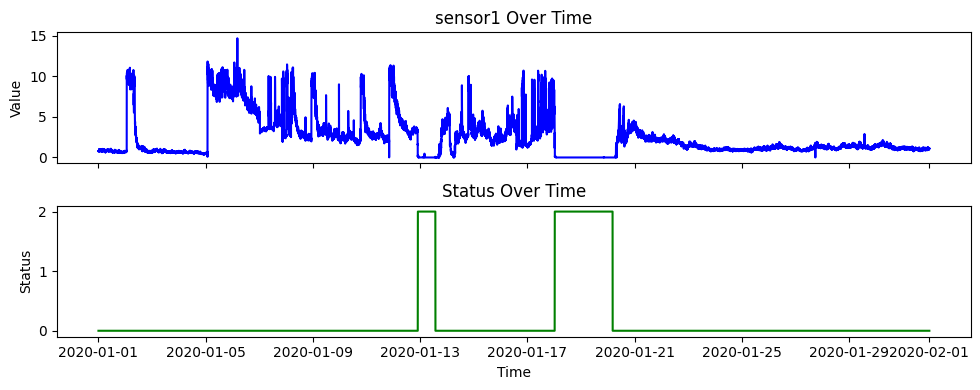

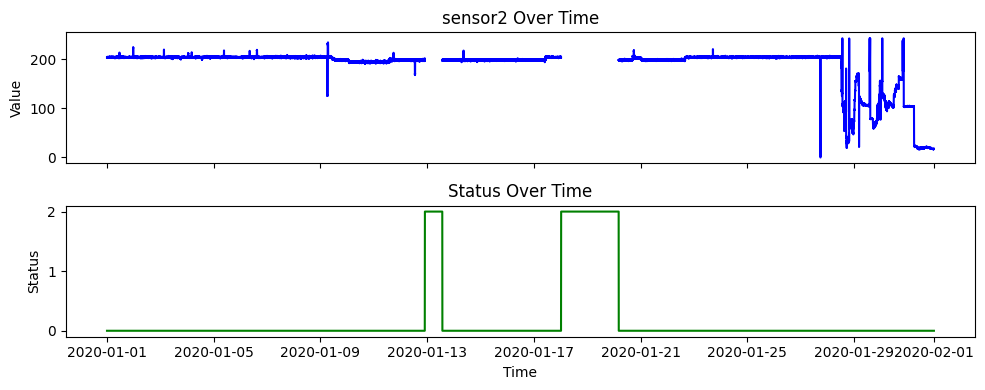

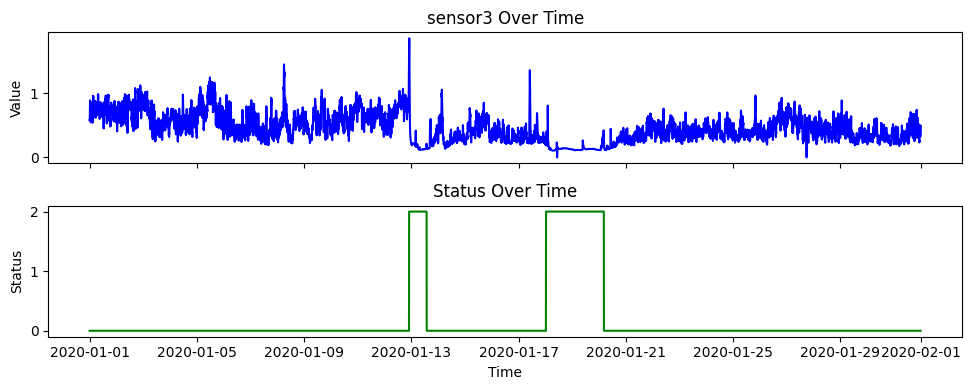

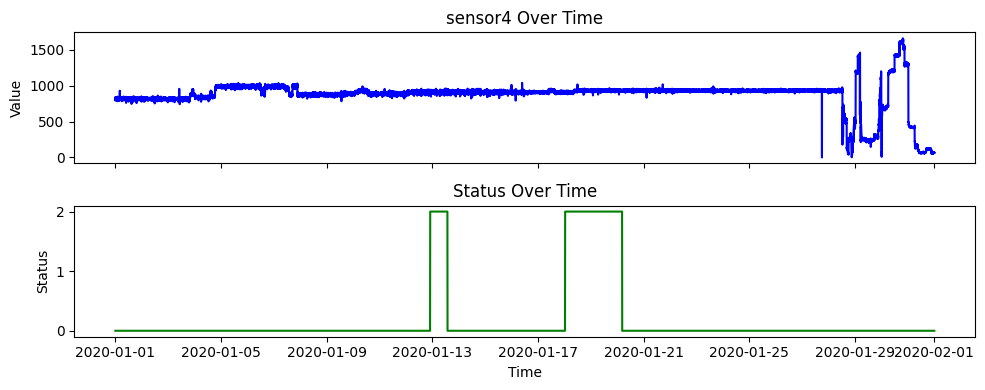

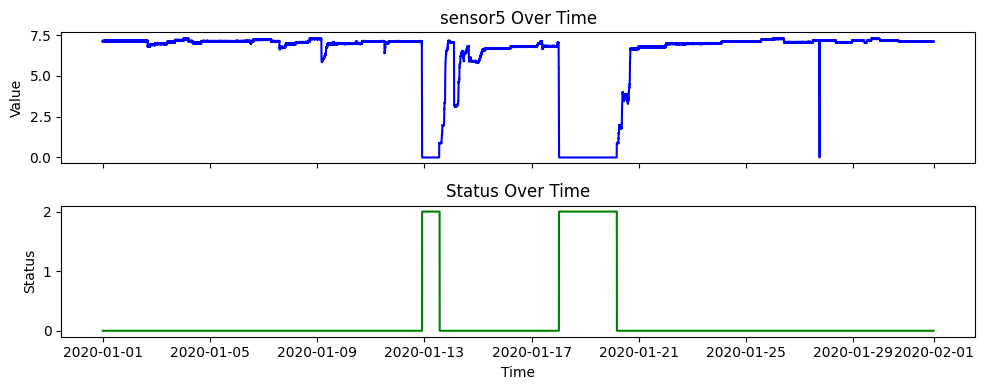

In [40]:
# Loop through all the columns except the last 2
for col in df.columns[:-2]:

  # Extract column data and status
  column_data= df[col]
  status_data= df['status']
  time_data= df.index

  # Create the subplots: One for the column, one for the status
  fig, axes= plt.subplots(nrows= 2, ncols= 1, figsize= (10,4), sharex= True)

  # Plot the column data
  axes[0].plot(time_data, column_data, label= col, color= 'blue')
  axes[0].set_ylabel('Value')
  axes[0].set_title(f'{col} Over Time')

  # Plot the status data
  axes[1].plot(time_data, status_data, label= 'Status', color= 'green')
  axes[1].set_xlabel('Time')
  axes[1].set_ylabel('Status')
  axes[1].set_title('Status Over Time')

  plt.tight_layout()
  plt.show()

### Key Insights from Time Series Plots of Sensors and Status

1. **Temperature Sensor**:
   - The temperature fluctuates between 15°C and 40°C throughout the observed period.
   - Significant drops in temperature correlate with changes in machine status, indicating possible cooling or malfunctions.
   
2. **Sensor5**:
   - The value remains relatively stable around 7.5, with abrupt drops corresponding to changes in machine status.
   - The relationship between this sensor and status indicates possible sensitivity to machine operation mode changes.

3. **Sensor4**:
   - The sensor data fluctuates around 1000 with intermittent sharp drops, particularly around machine status changes.
   - The spikes in values may signal anomalies or stress periods in machine operation.

4. **Sensor3**:
   - Sensor3 shows consistent variability with occasional sharp drops or spikes around status transitions.
   - The oscillations around a mean value may indicate operational noise with sensitivity to system changes.

5. **Sensor2**:
   - The value fluctuates near 200 but shows significant variation, particularly towards the end of the observed period.
   - The correlation with status changes suggests that sensor2 might be directly impacted by machine health or operational conditions.

6. **Sensor1**:
   - Sensor1 shows notable fluctuations, with several distinct periods of activity followed by idle phases.
   - The high variability near status changes suggests that this sensor reacts strongly to operational shifts.

7. **Pressure Sensor**:
   - Pressure remains stable around 50 for most of the time, with sharp drops aligning with status changes.
   - The correlation between pressure drop and system inactivity could signal a critical role of this sensor in machine functionality.

8. **Vibrations**:
   - Vibration data exhibits higher variability with sharp drops and spikes, correlating with machine status transitions.
   - The oscillating pattern suggests machine vibrations are a good indicator of operational state.

9. **RPM**:
   - RPM values remain relatively stable but exhibit significant drops when the status shifts, indicating a slowdown or pause in machine operation.
   - This sensor is likely tied directly to machine activity, with changes reflecting operating conditions.

10. **Humidity**:
    - The humidity sensor shows a gradual decline, with sharp decreases towards the end of the observed period.
    - The relationship with machine status changes indicates that humidity might be influenced by external or environmental conditions.

These insights reflect the interplay between sensor readings and machine status, where abrupt shifts in sensor values often coincide with transitions in operational status, indicating potential fault or maintenance needs.


In [41]:
# Add the first difference feature for all columns
df_diff= df.diff()

# Drop the first row because it only contains NaN values
df_diff= df_diff.dropna()

# Display the first few rows of the differenced data
df_diff.head()

,temperature,humidity,rpm,vibrations,pressure,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,status
time,,,,,,,,,,,,
2020-01-01 00:01:00,0.00000,0.0000,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2020-01-01 00:02:00,0.97178,-0.0912,0.0,0.27,0.0,0.012763,0.618460,-0.007474,35.796017,-0.059914,-0.102544,0.0
2020-01-01 00:03:00,-0.41673,-0.1531,0.0,-1.29,0.0,-0.060728,-0.047891,0.000000,-29.429750,0.045646,-0.008540,0.0
2020-01-01 00:04:00,0.27981,-0.1669,0.0,1.05,0.0,0.049131,-0.416160,0.008542,16.674700,-0.042792,0.042726,0.0
2020-01-01 00:05:00,0.28614,0.1601,0.0,-0.11,-1.0,-0.004869,-0.479740,0.023490,-4.636800,0.022823,0.068359,0.0


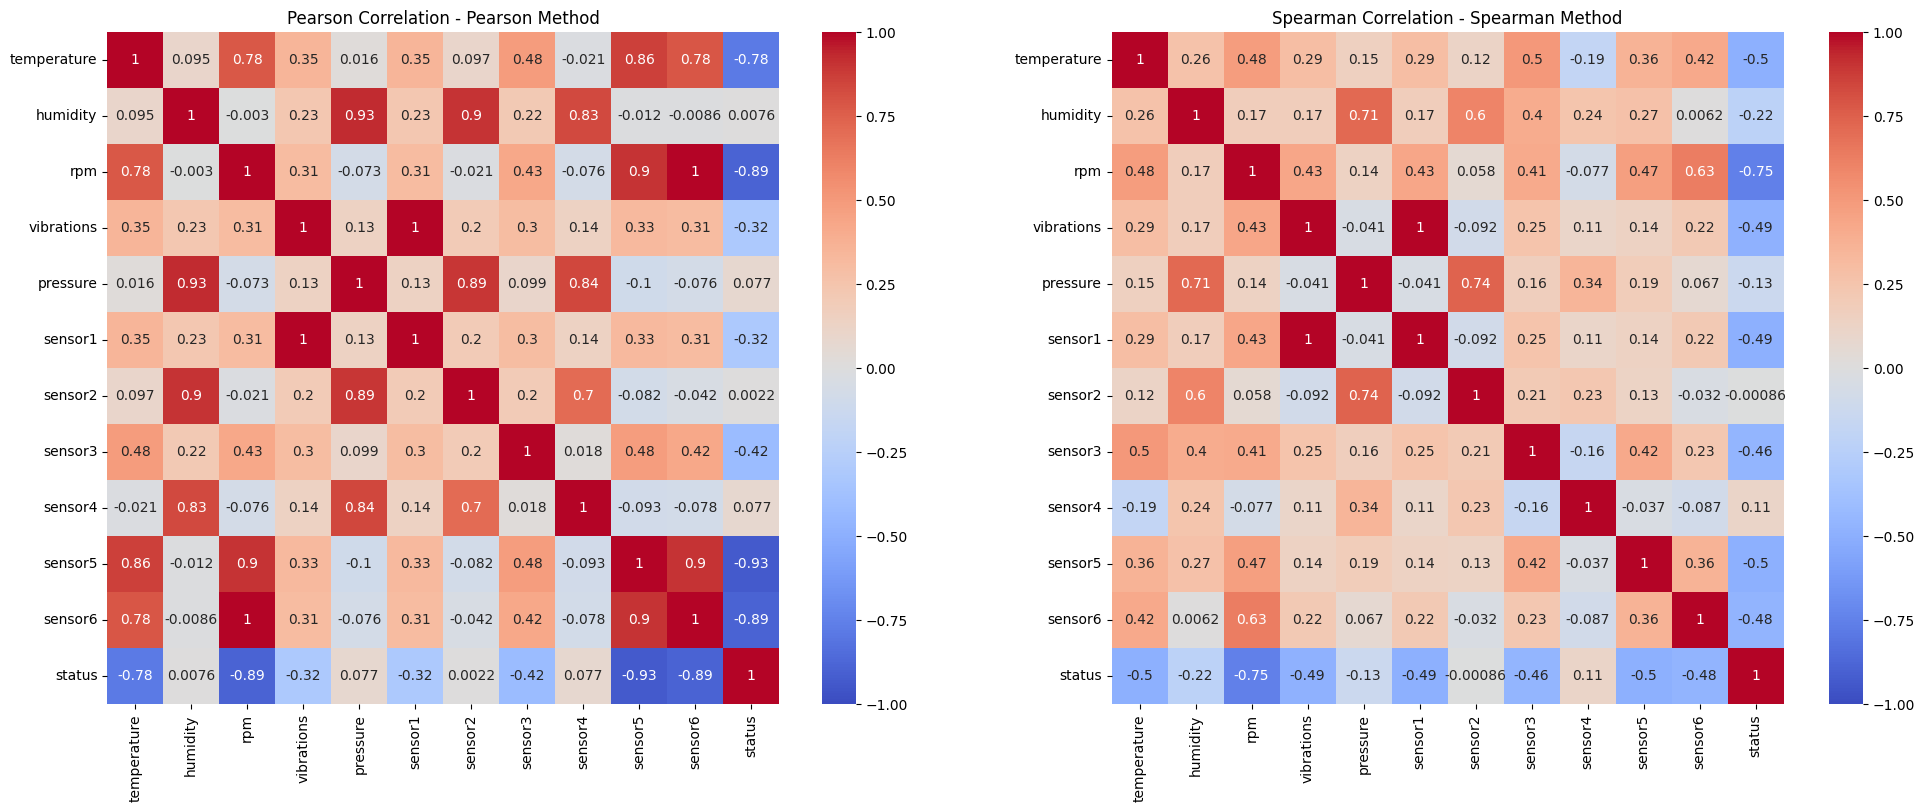

In [42]:
# Define a function to plot correlation matrices side by side
def plot_correlation_matrices(data, title1= 'Pearson Correlation', title2= 'Spearman Correlation'):
    fig, (ax1, ax2)= plt.subplots(figsize= (20, 8), ncols= 2, constrained_layout= True)

    # Pearson correlation
    sns.heatmap(data.corr(method= 'pearson'), annot= True, cmap= 'coolwarm', vmin= -1, vmax= 1, square= True, ax= ax1)
    ax1.set_title(f'{title1} - Pearson Method')

    # Spearman correlation
    sns.heatmap(data.corr(method= 'spearman'), annot= True, cmap= 'coolwarm', vmin= -1, vmax= 1, square= True, ax= ax2)
    ax2.set_title(f'{title2} - Spearman Method')

    plt.show()

# Plot both Pearson and Spearman correlation matrices side by side
plot_correlation_matrices(df, title1= 'Pearson Correlation', title2= 'Spearman Correlation')

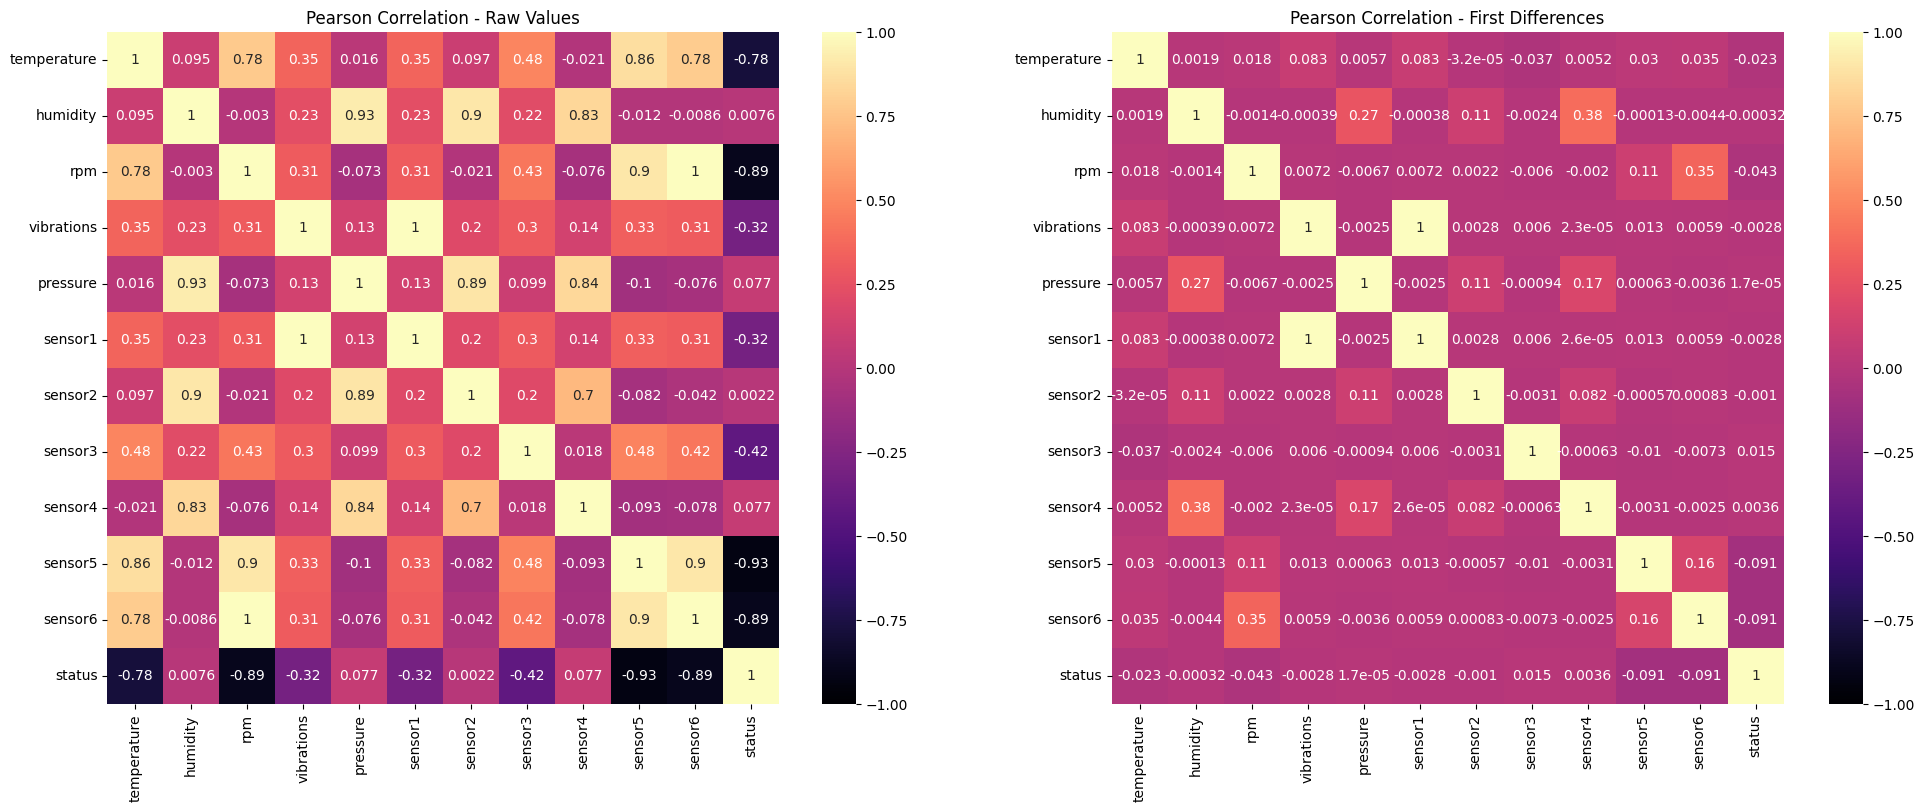

In [43]:
# Plot correlation matrices for raw values vs. first differences
fig, (ax1, ax2)= plt.subplots(figsize= (20,8), ncols= 2, constrained_layout= True)

# Pearson correlation for raw values
sns.heatmap(df.corr(method= 'pearson'), annot= True, cmap= 'magma', vmin= -1, vmax= 1, square= True, ax= ax1)
ax1.set_title('Pearson Correlation - Raw Values')

# Peaerson correlation for first differenced values
sns.heatmap(df_diff.corr(method= 'pearson'), annot= True, cmap= 'magma', vmin= -1, vmax= 1, square= True, ax= ax2)
ax2.set_title('Pearson Correlation - First Differences')

plt.show()

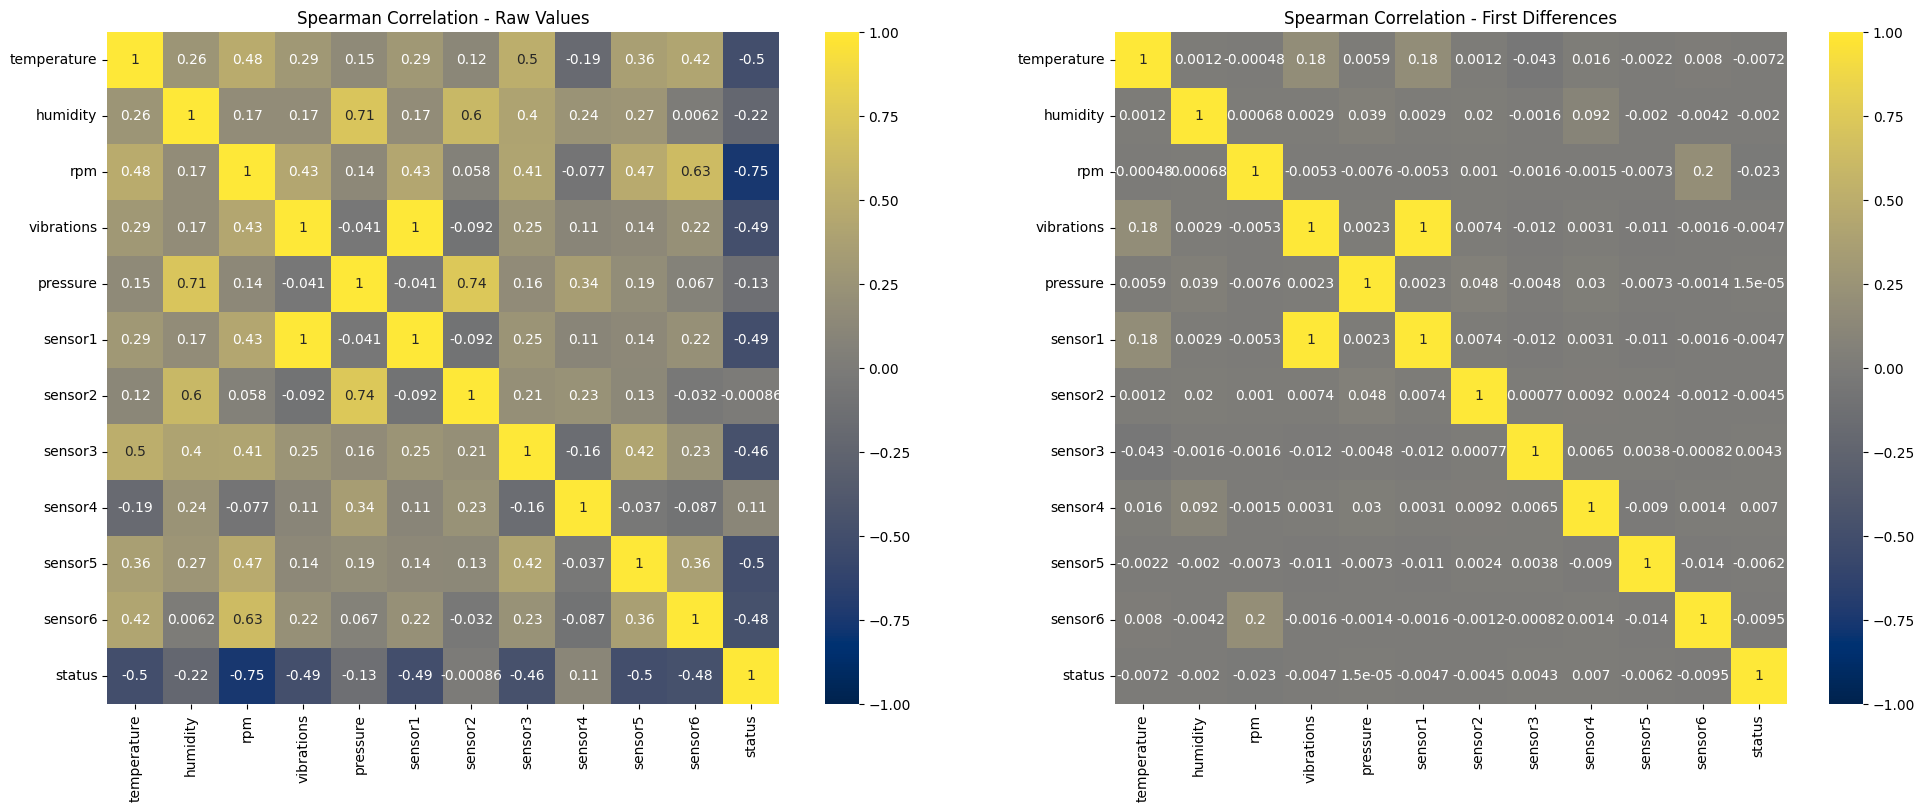

In [44]:
# Repeat the same for the Spearman correlation
fig, (ax1, ax2)= plt.subplots(figsize= (20, 8), ncols= 2, constrained_layout= True)

# Spearman correlation for raw values
sns.heatmap(df.corr(method= 'spearman'), annot= True, cmap= 'cividis', vmin= -1, vmax= 1, square= True, ax= ax1)
ax1.set_title('Spearman Correlation - Raw Values')

# Spearman correlation for first-differenced values
sns.heatmap(df_diff.corr(method= 'spearman'), annot= True, cmap='cividis', vmin= -1, vmax= 1, square= True, ax= ax2)
ax2.set_title('Spearman Correlation - First Differences')

plt.show()

### Correlation Analysis

The correlation analysis shows that **temperature, RPM, sensor 5, and sensor 6** have strong negative correlations with machine **status**, indicating that higher values of these variables are associated with a non-normal status (broken or recovering). Particularly, **RPM** and **sensor 5** show the strongest negative correlations with status across both Pearson and Spearman methods.

Additionally, **pressure and humidity** are highly positively correlated, suggesting that these two variables tend to increase together. While first-difference correlations show much weaker relationships, the main insight remains that short-term changes in key variables (e.g., temperature, RPM) have minimal direct impact on status, reflecting the long-term nature of these correlations.


In [45]:
# Drop 'sensor1' column based on previous correlation insight
df= df.drop(columns= ['sensor1'])

In [46]:
# Adding time-based features
df['month']= df.index.month
df['weekday']= df.index.dayofweek
df['hour']= df.index.hour
df['hours_since']= (df.index - df.index[0]).total_seconds() / 3600 # Hours since the first timestamp

In [47]:
# Aggregating by weekday and calculating the mean of all features
weekday_means= df.groupby('weekday').mean().round(2)
weekday_means

,temperature,humidity,rpm,vibrations,pressure,sensor2,sensor3,sensor4,sensor5,sensor6,status,month,hour,hours_since
weekday,,,,,,,,,,,,,,
0,19.92,69.17,60.36,61.01,74.99,202.14,0.35,938.09,4.93,13.26,0.38,1.0,11.5,383.99
1,26.27,62.50,70.73,57.93,68.79,186.35,0.39,862.16,6.65,15.47,0.00,1.0,11.5,407.99
2,33.63,62.39,72.01,47.41,65.65,183.60,0.50,809.68,6.99,15.88,0.00,1.0,11.5,347.99
3,33.47,68.68,71.80,55.17,73.82,187.07,0.47,946.72,6.96,15.82,0.00,1.0,11.5,371.99
4,31.10,57.16,72.28,44.38,64.87,169.12,0.46,756.40,7.03,15.91,0.00,1.0,11.5,395.99
5,25.71,68.40,58.54,29.18,74.56,201.56,0.45,906.36,5.37,12.91,0.49,1.0,11.5,335.99
6,24.67,69.27,55.20,71.50,74.77,202.28,0.53,942.62,5.19,12.15,0.54,1.0,11.5,359.99


In [48]:
# Filter for normal operations (Status= 0)
normal_ops= df[df['status'] == 0]

# Group by weekday for normal operations
normal_day_means= normal_ops.groupby('weekday').mean().round(2)
normal_day_means

,temperature,humidity,rpm,vibrations,pressure,sensor2,sensor3,sensor4,sensor5,sensor6,status,month,hour,hours_since
weekday,,,,,,,,,,,,,,
0,24.51,70.13,68.13,75.07,75.19,202.14,0.40,943.17,6.06,14.92,0.0,1.0,12.95,395.48
1,26.27,62.50,70.73,57.93,68.79,186.35,0.39,862.16,6.65,15.47,0.0,1.0,11.50,407.99
2,33.63,62.39,72.01,47.41,65.65,183.60,0.50,809.68,6.99,15.88,0.0,1.0,11.50,347.99
3,33.47,68.68,71.80,55.17,73.82,187.07,0.47,946.72,6.96,15.82,0.0,1.0,11.50,371.99
4,31.10,57.16,72.28,44.38,64.87,169.12,0.46,756.40,7.03,15.91,0.0,1.0,11.50,395.99
5,33.97,69.03,71.92,38.47,74.45,201.56,0.54,900.11,7.11,15.87,0.0,1.0,11.42,308.68
6,33.86,70.86,71.99,98.15,75.00,202.28,0.67,946.66,7.12,15.86,0.0,1.0,11.17,333.33


In [49]:
# Cross tabulation of 'hour' vs. 'weekday'
xtab= pd.crosstab(normal_ops['hour'], normal_ops['weekday'])
xtab.index.name= 'hour'; xtab.columns.name= 'day'
xtab

day,0,1,2,3,4,5,6
hour,,,,,,,
0,120,240,300,300,300,210,180
1,120,240,300,300,300,180,180
2,120,240,300,300,300,180,180
3,120,240,300,300,300,180,180
4,159,240,300,300,300,180,180
5,180,240,300,300,300,180,180
6,180,240,300,300,300,180,180
7,180,240,300,300,300,180,180
8,180,240,300,300,300,180,180


In [50]:
# Group by hour and calculate the mean for only normal operations
hourly_means= normal_ops.groupby('hour').mean().round(2)
hourly_means

,temperature,humidity,rpm,vibrations,pressure,sensor2,sensor3,sensor4,sensor5,sensor6,status,month,weekday,hours_since
hour,,,,,,,,,,,,,,
0,32.00,67.68,71.88,60.40,71.87,192.60,0.48,886.43,6.99,15.83,0.0,1.0,3.07,356.12
1,33.04,66.46,71.70,64.84,71.93,194.23,0.52,894.63,7.02,15.81,0.0,1.0,3.04,356.16
2,33.11,66.61,71.52,66.20,72.05,193.89,0.49,898.59,6.97,15.76,0.0,1.0,3.04,357.16
3,32.35,66.72,71.42,61.68,72.11,193.98,0.52,901.78,6.89,15.73,0.0,1.0,3.04,358.16
4,31.06,66.07,69.96,64.03,71.78,192.55,0.49,890.99,6.71,15.43,0.0,1.0,2.97,361.54
5,30.46,65.22,69.13,64.42,71.48,191.48,0.46,867.75,6.66,15.26,0.0,1.0,2.93,363.78
6,29.74,65.71,69.74,63.42,70.47,188.32,0.47,870.69,6.72,15.40,0.0,1.0,2.93,364.78
7,30.40,65.76,70.58,59.98,70.35,188.66,0.48,872.39,6.78,15.62,0.0,1.0,2.93,365.78
8,31.01,65.73,70.88,57.49,70.41,188.64,0.47,871.61,6.83,15.62,0.0,1.0,2.93,366.78


In [51]:
# Define a function to plot data segment
def plot_subset_of_series(series, index_loc, w= 30):

  # Define the window to plot around the index
  start= index_loc - pd.Timedelta(minutes= w)
  end= index_loc + pd.Timedelta(minutes= w)

  # Subset the series to the specified window
  subset= series[start:end]

  # Plot the subset of data
  plt.figure(figsize= (10,4))
  plt.plot(subset.index, subset.values, label= series.name)

  # Format plot
  plt.title(f"Centered on: {index_loc}")
  plt.xlabel('Time')
  plt.ylabel(series.name)
  plt.xticks(rotation= 45)
  plt.tight_layout()

  # Show the plot
  plt.show()

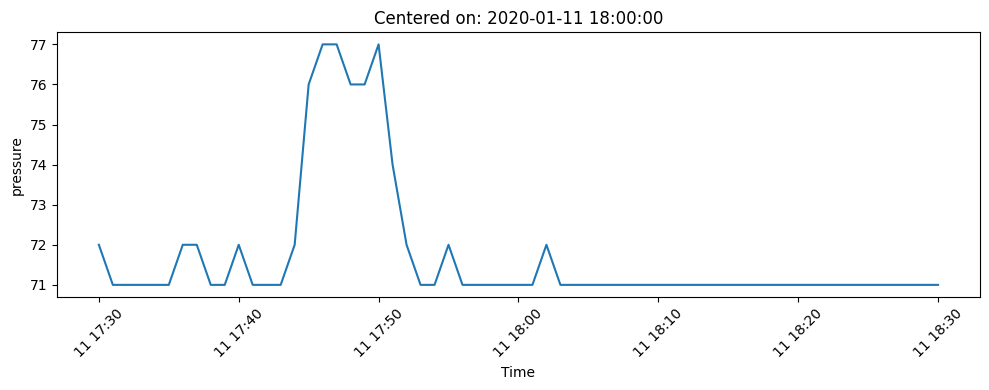

In [52]:
# Plot example of outlier pressure data (sensor spike)
index_pressure_outlier= pd.Timestamp('2020-01-11 18:00:00')
plot_subset_of_series(df.pressure, index_pressure_outlier, w= 30)

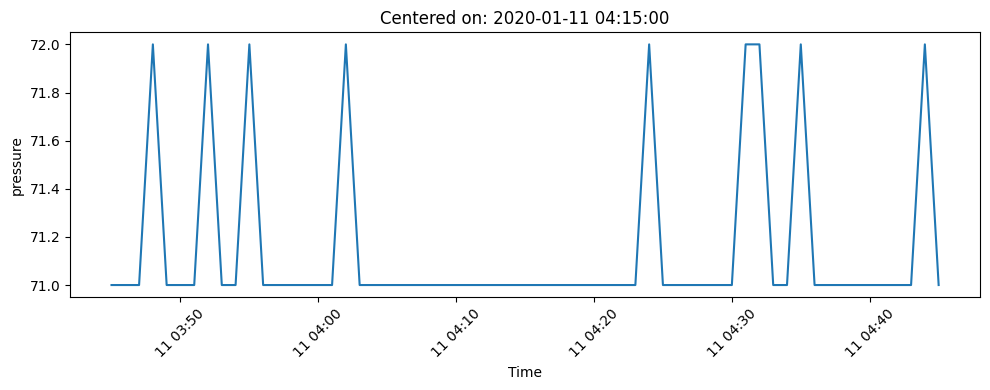

In [53]:
# Plot example of normal pressure data
index_pressure_normal= pd.Timestamp('2020-01-11 04:15:00')
plot_subset_of_series(df.pressure, index_pressure_normal, w= 30)

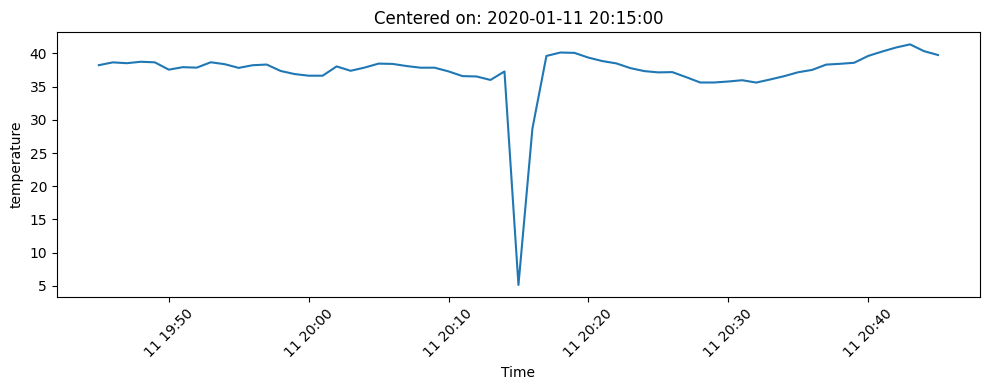

In [54]:
# Plot example of outlier temperature data (sharp drop)
index_temperature_outlier= pd.Timestamp('2020-01-11 20:15:00')
plot_subset_of_series(df.temperature, index_temperature_outlier, w= 30)

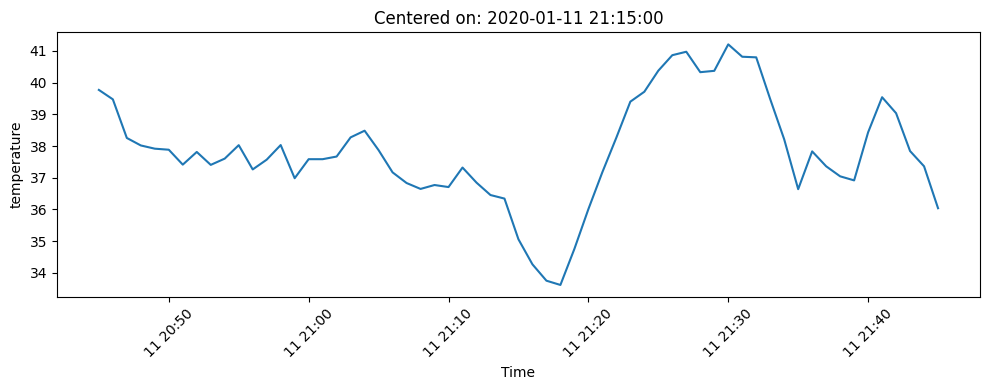

In [55]:
# Plot example of normal temperature data
index_temperature_normal= pd.Timestamp('2020-01-11 21:15:00')
plot_subset_of_series(df.temperature, index_temperature_normal, w= 30)

In [102]:
def preprocess_data(df):

    # Handle missing values
    df= df.interpolate()  # Linear interpolation for missing values

    # Feature engineering
    df['temp_humidity_ratio']= df['temperature'] / df['humidity'].replace(0, np.nan)
    df['vibration_rpm_ratio']= df['vibrations'] / df['rpm'].replace(0, np.nan)

    # Create lagged features for numerical sensors
    sensor_columns= ['temperature', 'humidity', 'rpm', 'vibrations', 'pressure',
                      'sensor2', 'sensor3', 'sensor4', 'sensor5', 'sensor6']

    for col in sensor_columns:
        df[f'{col}_change']= df[col].diff()
        for lag in [1, 6, 24]:
            df[f'{col}_lag_{lag}']= df[col].shift(lag)

    # Detect anomalies (using IQR method)
    def detect_anomalies(series):
        Q1= series.quantile(0.25)
        Q3= series.quantile(0.75)
        IQR= Q3 - Q1
        lower_bound= Q1 - 1.5 * IQR
        upper_bound= Q3 + 1.5 * IQR
        return ((series < lower_bound) | (series > upper_bound))

    for col in sensor_columns:
        df[f'{col}_anomaly']= detect_anomalies(df[col])

    # Create cyclical features for time-based columns
    df['month_sin']= np.sin(df['month'] * (2 * np.pi / 12))
    df['month_cos']= np.cos(df['month'] * (2 * np.pi / 12))
    df['weekday_sin']= np.sin(df['weekday'] * (2 * np.pi / 7))
    df['weekday_cos']= np.cos(df['weekday'] * (2 * np.pi / 7))
    df['hour_sin']= np.sin(df['hour'] * (2 * np.pi / 24))
    df['hour_cos']= np.cos(df['hour'] * (2 * np.pi / 24))

    # Replace infinite values with NaN
    df= df.replace([np.inf, -np.inf], np.nan)

    # Drop rows with NaN values
    df= df.dropna()

    # Encode the target variable
    le= LabelEncoder()
    df['status_encoded']= le.fit_transform(df['status'])

    return df, le

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7892
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00       373

    accuracy                           1.00      8266
   macro avg       0.67      0.67      0.67      8266
weighted avg       1.00      1.00      1.00      8266



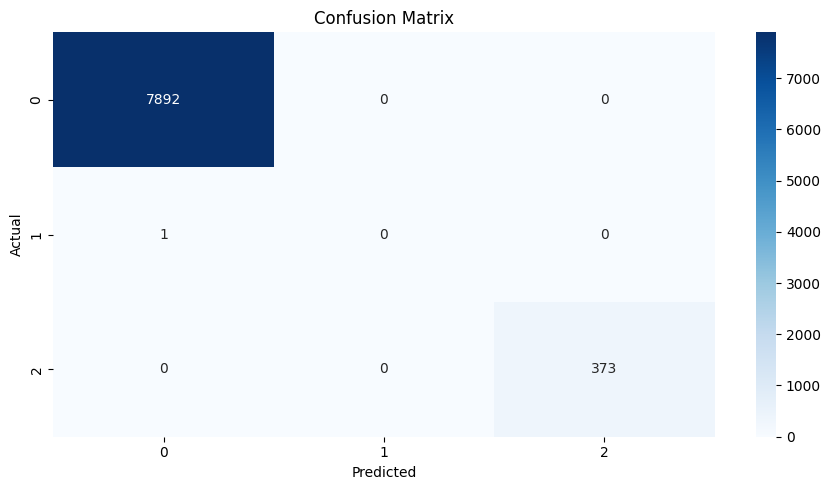

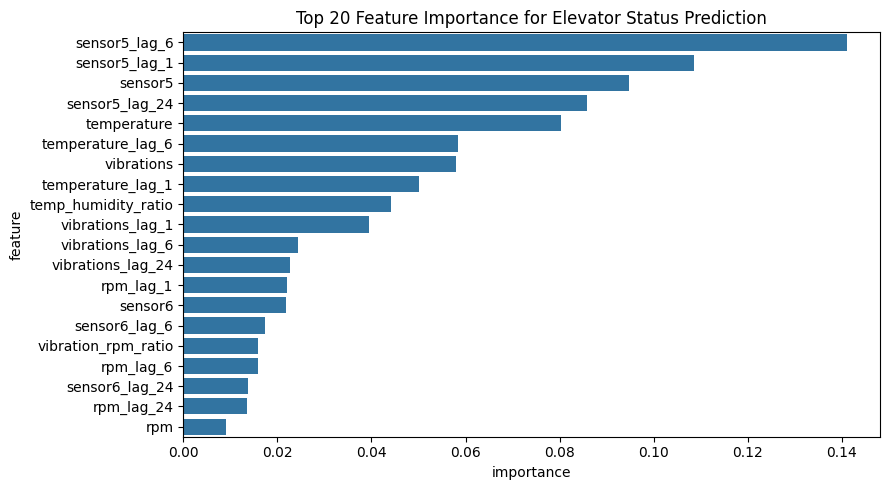

In [117]:

def train_model(df, le):
    # Prepare features and target
    features = [col for col in df.columns if col not in ['status', 'status_encoded']]
    X = df[features]
    y = df['status_encoded']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train a Random Forest model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Convert integer classes to strings for reporting
    target_names = [str(cls) for cls in le.classes_]

    # Evaluate the model
    print(classification_report(y_test, y_pred, target_names=target_names))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(9,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Feature importance
    feature_importance = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    plt.figure(figsize=(9,5))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
    plt.title('Top 20 Feature Importance for Elevator Status Prediction')
    plt.tight_layout()
    plt.show()

    return model, scaler, features

# Preprocess the data
df_processed, label_encoder = preprocess_data(df)

# Train and evaluate the model
model, scaler, features = train_model(df_processed, label_encoder)

### Addressing Class Imbalance and Overfitting

#### 1. Class Imbalance Problem
In the dataset, there was significant class imbalance in the target variable (`status`), which records the operational state of the elevator. The distribution of classes is as follows:
- Class `0`: Normal operations (the majority class) with 7892 examples.
- Class `1`: Extremely rare operational state with only 1 example.
- Class `2`: Broken or recovering state with 373 examples.

The challenge with this imbalance is that the model tends to be biased towards the majority class (`0`), as there is not enough representation from the minority classes, especially class `1`. This results in poor predictions for classes `1` and `2`, causing the model to underperform when predicting rare events (elevator failures or recoveries).

#### 2. Overfitting Issue
Overfitting became a significant issue during model training. Despite attempting to address the class imbalance, the models displayed near-perfect precision, recall, and F1-scores, particularly for class `0` and `2`. For example:

The performance indicates that the model is overfitting on the majority class and memorizing the minority class data without generalizing well. The near-perfect scores for class `0` and `2`, coupled with the poor performance on class `1`, highlight the difficulty of learning meaningful patterns from an imbalanced dataset.

#### 3. Techniques Applied and Their Outcomes
- **Random Oversampling:** I applied the `RandomOverSampler` to balance the dataset by increasing the representation of the minority classes (`1` and `2`). While this technique balances the dataset, it often results in overfitting, as the model learns to "memorize" the oversampled examples without capturing generalized patterns.
  
- **Excluding Rare Class (`1`):** To simplify the problem, I tried excluding class `1` from the dataset and focused on class `0` (normal operations) and class `2` (broken/recovering). This approach slightly improved performance but did not fully solve the overfitting problem.

#### 4. Why the Techniques Didn't Work
- **Random Oversampling:** Although oversampling addressed the class imbalance, it introduced duplicate records of the minority class. This led to overfitting, where the model became too reliant on memorized data rather than learning general trends.
  
- **Extreme Imbalance:** Despite addressing the imbalance, the majority class (`0`) still dominated the model's predictions, with minority class (`2`) often getting accurate predictions only because of its higher presence compared to class `1`.

#### Conclusion
The imbalance in the dataset poses a challenge for accurate classification. Despite using techniques like oversampling and class exclusion, the model still struggles with overfitting and poor generalization.